# **Sistema de alarmas - Aguacate**

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

df_BA29  = pd.read_excel("DB_CropX_Aguacate.xlsx", sheet_name='CropX_BA29')

# Asegurarnos de convertir la columna de tiempo a datetime (si es que no lo está)
for df in [df_BA29]:
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'])


Saving DB_CropX_Aguacate.xlsx to DB_CropX_Aguacate (1).xlsx


## **Librerías**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
from typing import Dict, Any
from tabulate import tabulate

In [ ]:
pip install pyod

# **PRUEBAS AJUSTE**

In [ ]:
# --- CONFIGURACIÓN DE RANGOS Y MENSAJES ---
RANGOS_OPTIMOS_AGUACATE = {
    "moisture_top":       (0, 100),
    "moisture_medium":    (0, 100),
    "temperature_top":    (15, 24),
    "temperature_medium": (15, 24),
    "conductivity_top":   (300, 3000),
    "conductivity_medium":(300, 3000),
}

MENSAJES_ADVERTENCIA_AGUACATE = {
    "moisture_low":       "Causará marchitamiento y caída de hojas.",
    "moisture_high":      "Riesgo de enfermedades y asfixia radicular.",
    "temperature_low":    "Afecta el crecimiento y desarrollo del fruto.",
    "temperature_high":   "Puede provocar la caída de flores y frutos jóvenes.",
    "conductivity_low":   "Puede limitar la disponibilidad de nutrientes.",
    "conductivity_high":  "Puede causar estrés salino y afectar rendimiento.",
}

# --- FUNCIONES AUXILIARES ---
def evaluar_variable(nombre: str, valor: float):
    mn, mx = RANGOS_OPTIMOS_AGUACATE[nombre]
    base = nombre.split('_')[0]
    if valor < mn:
        return "bajo", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_low", "")
    if valor > mx:
        return "alto", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_high", "")
    return "ok", ""

def detectar_atipicos_iqr(df: pd.DataFrame) -> Dict[str, int]:
    """
    Detecta outliers univariados por IQR: valores < Q1-1.5*IQR o > Q3+1.5*IQR.
    Retorna {col: n_outliers}.
    """
    out = {}
    for col in df.columns:
        series = df[col].dropna()
        if series.empty:
            continue
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        low  = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        cnt = int(((series < low) | (series > high)).sum())
        if cnt > 0:
            out[col] = cnt
    return out

def analyze_agucate_df(path_excel: str, sheet_name: str, nrows: int=None) -> Dict[str,Any]:
    df = pd.read_excel(path_excel, sheet_name=sheet_name, nrows=nrows)
    mapping = {
        'VWC-20cm':      'moisture_top',
        'VWC-41cm':      'moisture_medium',
        'Temp(C)-20cm':  'temperature_top',
        'Temp(C)-41cm':  'temperature_medium',
        'EC(dS/m)-20cm': 'conductivity_top',
        'EC(dS/m)-41cm': 'conductivity_medium'
    }
    df = df.rename(columns=mapping)
    vars_eval = list(mapping.values())
    df_eval = df[vars_eval].astype(float)

    fuera_rango = defaultdict(int)
    advertencias = defaultdict(set)
    for col in vars_eval:
        for val in df_eval[col].dropna():
            estado, msg = evaluar_variable(col, val)
            if estado != "ok":
                fuera_rango[col] += 1
                if msg:
                    advertencias[col].add(msg)

    atipicos = detectar_atipicos_iqr(df_eval)

    reporte = {"resumen":"", "fuera_rango":{}, "atipicos":{}}
    if fuera_rango:
        reporte["resumen"]="Se detectaron valores fuera de rango."
        for var,cnt in fuera_rango.items():
            reporte["fuera_rango"][var] = {
                "registros_fuera":cnt,
                "advertencias": list(advertencias[var])
            }
    else:
        reporte["resumen"]="Todas las variables dentro de rango."
    if atipicos:
        for var,cnt in atipicos.items():
            reporte["atipicos"][var]={"valores_atipicos":cnt}
    else:
        reporte["atipicos"]="No se detectaron datos atípicos."
    return reporte

# --- EJEMPLO DE USO ---
if __name__ == "__main__":
    path  = "/content/DB_CropX_Aguacate.xlsx"
    sheet = "CropX_BA29"
    reporte = analyze_agucate_df(path, sheet, nrows=10000)
    import json
    print(json.dumps(reporte, indent=2, ensure_ascii=False))


{
  "resumen": "Se detectaron valores fuera de rango.",
  "fuera_rango": {
    "conductivity_top": {
      "registros_fuera": 10000,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    },
    "conductivity_medium": {
      "registros_fuera": 9994,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    }
  },
  "atipicos": {
    "moisture_top": {
      "valores_atipicos": 1386
    },
    "temperature_top": {
      "valores_atipicos": 4
    },
    "temperature_medium": {
      "valores_atipicos": 1
    },
    "conductivity_top": {
      "valores_atipicos": 1548
    },
    "conductivity_medium": {
      "valores_atipicos": 1
    }
  }
}


In [ ]:

try:
    from pyod.models.mad import MAD
    USE_PYOD = True
except ImportError:
    USE_PYOD = False
    print("pyod no disponible: se usará método IQR para detección de atípicos.")

# --- CONFIGURACIÓN DE RANGOS Y MENSAJES ---
RANGOS_OPTIMOS_AGUACATE = {
    "moisture_top":       (0, 100),
    "moisture_medium":    (0, 100),
    "temperature_top":    (15, 24),
    "temperature_medium": (15, 24),
    "conductivity_top":   (300, 3000),
    "conductivity_medium":(300, 3000),
}

MENSAJES_ADVERTENCIA_AGUACATE = {
    "moisture_low":       "Causará marchitamiento y caída de hojas.",
    "moisture_high":      "Riesgo de enfermedades y asfixia radicular.",
    "temperature_low":    "Afecta el crecimiento y desarrollo del fruto.",
    "temperature_high":   "Puede provocar la caída de flores y frutos jóvenes.",
    "conductivity_low":   "Puede limitar la disponibilidad de nutrientes.",
    "conductivity_high":  "Puede causar estrés salino y afectar rendimiento.",
}

# --- FUNCIONES AUXILIARES ---
def evaluar_variable(nombre: str, valor: float):
    mn, mx = RANGOS_OPTIMOS_AGUACATE[nombre]
    base = nombre.split('_')[0]
    if valor < mn:
        return "bajo", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_low", "")
    if valor > mx:
        return "alto", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_high", "")
    return "ok", ""

def detectar_atipicos(df: pd.DataFrame) -> Dict[str, int]:
    df_clean = df.dropna(axis=1, how="all")
    if df_clean.shape[0] < 5:
        return {}
    scaler = StandardScaler()
    X_std = scaler.fit_transform(df_clean)
    X_std = pd.DataFrame(X_std, columns=df_clean.columns)
    outliers = {}
    if USE_PYOD:
        mad = MAD(threshold=3.0)
        for col in X_std.columns:
            labels = mad.fit_predict(X_std[[col]].values)
            cnt = int(labels.sum())
            if cnt>0:
                outliers[col] = cnt
    else:
        # fallback IQR
        for col in X_std.columns:
            series = X_std[col]
            Q1, Q3 = series.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            cnt = int(((series < low) | (series > high)).sum())
            if cnt>0:
                outliers[col] = cnt
    return outliers

def analyze_agucate_df(
    path_excel: str,
    sheet_name: str,
    start_date: str = None,
    end_date: str = None,
    nrows: int = None
) -> Dict[str, Any]:
    """
    Analiza registros de un día o rango y devuelve variables fuera de rango y atípicos.
    """
    df = pd.read_excel(path_excel, sheet_name=sheet_name, nrows=nrows)
    df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])
    df = df.set_index('Fecha_Hora').sort_index()

    # Filtrar fechas
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]

    mapping = {
        'VWC-20cm':      'moisture_top',
        'VWC-41cm':      'moisture_medium',
        'Temp(C)-20cm':  'temperature_top',
        'Temp(C)-41cm':  'temperature_medium',
        'EC(dS/m)-20cm': 'conductivity_top',
        'EC(dS/m)-41cm': 'conductivity_medium'
    }
    df = df.rename(columns=mapping)
    vars_eval = list(mapping.values())
    df_eval = df[vars_eval].astype(float)

    fuera_rango, advertencias = defaultdict(int), defaultdict(set)
    for col in vars_eval:
        for val in df_eval[col].dropna():
            estado, msg = evaluar_variable(col, val)
            if estado!="ok":
                fuera_rango[col]+=1
                if msg:
                    advertencias[col].add(msg)

    atipicos = detectar_atipicos(df_eval)
    reporte = {"resumen":"", "fuera_rango":{}, "atipicos":{}}
    if fuera_rango:
        reporte["resumen"]="Se detectaron valores fuera de rango."
        for var,cnt in fuera_rango.items():
            reporte["fuera_rango"][var]={"registros_fuera":cnt, "advertencias":list(advertencias[var])}
    else:
        reporte["resumen"]="Todas las variables dentro de rango."
    if atipicos:
        for var,cnt in atipicos.items():
            reporte["atipicos"][var]={"valores_atipicos":cnt}
    else:
        reporte["atipicos"]="No se detectaron datos atípicos."
    return reporte

# --- EJEMPLO DE USO ---
if __name__=="__main__":
    path="/content/DB_CropX_Aguacate.xlsx"  # ajústalo a tu ruta
    sheet="CropX_BA29"
    # Un día
    rep_dia   = analyze_agucate_df(path, sheet, start_date="2024-04-06", end_date="2025-04-06")
    # Rango
    rep_rango = analyze_agucate_df(path, sheet, start_date="2024-04-06", end_date="2025-01-26")
    import json
    import json
    print("Reporte día:\n", json.dumps(rep_dia, indent=2, ensure_ascii=False))
    print("Reporte rango:\n", json.dumps(rep_rango, indent=2, ensure_ascii=False))


Reporte día:
 {
  "resumen": "Se detectaron valores fuera de rango.",
  "fuera_rango": {
    "conductivity_top": {
      "registros_fuera": 13374,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    },
    "conductivity_medium": {
      "registros_fuera": 13369,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    }
  },
  "atipicos": {
    "moisture_top": {
      "valores_atipicos": 1368
    },
    "temperature_top": {
      "valores_atipicos": 110
    },
    "temperature_medium": {
      "valores_atipicos": 374
    },
    "conductivity_top": {
      "valores_atipicos": 1583
    },
    "conductivity_medium": {
      "valores_atipicos": 1523
    }
  }
}
Reporte rango:
 {
  "resumen": "Se detectaron valores fuera de rango.",
  "fuera_rango": {
    "conductivity_top": {
      "registros_fuera": 13367,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    },
    "conduct

# **PRUEBA FINAL**

In [ ]:


# Intentar importar MAD de pyod, fallback a IQR
try:
    from pyod.models.mad import MAD
    USE_PYOD = True
except ImportError:
    USE_PYOD = False

# --- CONFIGURACIÓN DE RANGOS Y MENSAJES ---
RANGOS_OPTIMOS_AGUACATE = {
    "moisture_top":       (0, 100),
    "moisture_medium":    (0, 100),
    "temperature_top":    (15, 24),
    "temperature_medium": (15, 24),
    "conductivity_top":   (300, 3000),
    "conductivity_medium":(300, 3000),
}
MENSAJES_ADVERTENCIA_AGUACATE = {
    "moisture_low":       "Causará marchitamiento y caída de hojas.",
    "moisture_high":      "Riesgo de enfermedades y asfixia radicular.",
    "temperature_low":    "Afecta el crecimiento y desarrollo del fruto.",
    "temperature_high":   "Puede provocar la caída de flores y frutos jóvenes.",
    "conductivity_low":   "Puede limitar la disponibilidad de nutrientes.",
    "conductivity_high":  "Puede causar estrés salino y afectar rendimiento.",
}

# --- TRANSFORMACIÓN DE HUMEDAD ---
def transformar_moisture_aguacate(valor: float, capa: str) -> float:
    """
    Transforma valor del sensor de humedad a porcentaje según capa.
    """
    if capa == "top":
        return (valor - 20) / (40 - 20) * 100
    elif capa == "medium":
        return (valor - 25) / (45 - 25) * 100
    elif capa == "bottom":
        return (valor - 30) / (50 - 30) * 100
    return valor

# --- EVALUACIÓN Y DETECCIÓN DE ATÍPICOS ---
def evaluar_variable(nombre: str, valor: float):
    mn, mx = RANGOS_OPTIMOS_AGUACATE[nombre]
    base = nombre.split('_')[0]
    if valor < mn:
        return "bajo", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_low", "")
    if valor > mx:
        return "alto", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_high", "")
    return "ok", ""

def detectar_atipicos(df: pd.DataFrame) -> Dict[str, int]:
    df_clean = df.dropna(axis=1, how="all")
    if df_clean.shape[0] < 5:
        return {}
    scaler = StandardScaler()
    X_std = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)
    outliers = {}
    if USE_PYOD:
        mad = MAD(threshold=3.0)
        for col in X_std.columns:
            cnt = int(mad.fit_predict(X_std[[col]].values).sum())
            if cnt: outliers[col] = cnt
    else:
        # fallback IQR
        for col in X_std.columns:
            s = X_std[col]
            Q1, Q3 = s.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            cnt = int(((s < Q1 - 1.5 * IQR) | (s > Q3 + 1.5 * IQR)).sum())
            if cnt: outliers[col] = cnt
    return outliers

# --- FUNCION PRINCIPAL ---
def analyze_agucate_df(
    path_excel: str,
    sheet_name: str,
    start_date: str = None,
    end_date: str = None,
    nrows: int = None
) -> Dict[str, Any]:
    df = pd.read_excel(path_excel, sheet_name=sheet_name, nrows=nrows)
    df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])
    df = df.set_index('Fecha_Hora').sort_index()
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]
    # Renombrar
    mapping = {
        'VWC-20cm':      'moisture_top',
        'VWC-41cm':      'moisture_medium',
        'Temp(C)-20cm':  'temperature_top',
        'Temp(C)-41cm':  'temperature_medium',
        'EC(dS/m)-20cm': 'conductivity_top',
        'EC(dS/m)-41cm': 'conductivity_medium'
    }
    df = df.rename(columns=mapping)
    vars_eval = list(mapping.values())
    # Aplicar transformación de humedad
    for capa in ['top', 'medium', 'bottom']:
        col = f"moisture_{capa}"
        if col in df.columns:
            df[col] = df[col].apply(lambda v: transformar_moisture_aguacate(v, capa) if pd.notna(v) else v)
    df_eval = df[vars_eval].astype(float)
    # Evaluación fuera de rango
    fuera, warns = defaultdict(int), defaultdict(set)
    for col in vars_eval:
        for val in df_eval[col].dropna():
            est, msg = evaluar_variable(col, val)
            if est != "ok":
                fuera[col] += 1
                if msg: warns[col].add(msg)
    # Atípicos
    atip = detectar_atipicos(df_eval)
    # Reporte
    rep = {"resumen":"", "fuera_rango":{}, "atipicos":{}}
    if fuera:
        rep["resumen"]="Se detectaron valores fuera de rango."
        for v,c in fuera.items():
            rep["fuera_rango"][v] = {"registros_fuera":c, "advertencias":list(warns[v])}
    else:
        rep["resumen"]="Todas las variables dentro de rango."
    rep["atipicos"] = {v:{"valores_atipicos":cnt} for v,cnt in atip.items()} if atip else "No se detectaron datos atípicos."
    return rep

# --- EJEMPLO ---
if __name__=="__main__":
    path="/content/DB_CropX_Aguacate.xlsx"
    sheet="CropX_BA29"
    rep_dia   = analyze_agucate_df(path, sheet, start_date="2024-04-06", end_date="2024-04-06")
    # Rango
    rep_rango = analyze_agucate_df(path, sheet, start_date="2024-04-06", end_date="2024-04-10")
    print("Reporte día:\n", json.dumps(rep_dia, indent=2, ensure_ascii=False))
    print("Reporte rango:\n", json.dumps(rep_rango, indent=2, ensure_ascii=False))


Reporte día:
 {
  "resumen": "Se detectaron valores fuera de rango.",
  "fuera_rango": {
    "moisture_top": {
      "registros_fuera": 1,
      "advertencias": [
        "Riesgo de enfermedades y asfixia radicular."
      ]
    },
    "moisture_medium": {
      "registros_fuera": 1,
      "advertencias": [
        "Riesgo de enfermedades y asfixia radicular."
      ]
    },
    "conductivity_top": {
      "registros_fuera": 1,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    },
    "conductivity_medium": {
      "registros_fuera": 1,
      "advertencias": [
        "Puede limitar la disponibilidad de nutrientes."
      ]
    }
  },
  "atipicos": "No se detectaron datos atípicos."
}
Reporte rango:
 {
  "resumen": "Se detectaron valores fuera de rango.",
  "fuera_rango": {
    "moisture_top": {
      "registros_fuera": 193,
      "advertencias": [
        "Riesgo de enfermedades y asfixia radicular."
      ]
    },
    "moisture_medium": {
   

In [ ]:


def print_agucate_report(report: dict, title: str):
    print(f"\n=== {title} ===\n")
    # 1) Resumen
    print(f"Resumen: {report.get('resumen', '—')}\n")

    # 2) Valores fuera de rango
    fr = report.get("fuera_rango", {})
    if fr:
        rows = []
        for var, info in fr.items():
            rows.append([
                var,
                info.get("registros_fuera", 0),
                "; ".join(info.get("advertencias", []))
            ])
        print("Valores fuera de rango:")
        print(tabulate(rows,
                       headers=["Variable", "N° Registros fuera", "Advertencias"],
                       tablefmt="github"))
        print()
    else:
        print("No se detectaron valores fuera de rango.\n")

    # 3) Valores atípicos
    at = report.get("atipicos", {})
    if isinstance(at, dict) and at:
        if all(isinstance(v, dict) and "valores_atipicos" in v for v in at.values()):
            rows = []
            for var, info in at.items():
                rows.append([var, info.get("valores_atipicos", 0)])
            print("Valores atípicos detectados:")
            print(tabulate(rows,
                           headers=["Variable", "N° Valores atípicos"],
                           tablefmt="github"))
            print()
        else:
            print(f"Atípicos: {at}\n")
    else:
        print("No se detectaron datos atípicos.\n")

# --- Ejemplo de uso ---
if __name__ == "__main__":
    import json
    # Suponiendo rep_dia y rep_rango ya disponibles
    # rep_dia = analyze_agucate_df(...)
    # rep_rango = analyze_agucate_df(...)
    print_agucate_report(rep_dia,   "Reporte para el día")
    print_agucate_report(rep_rango, "Reporte para rango")



=== Reporte para el día ===

Resumen: Se detectaron valores fuera de rango.

Valores fuera de rango:
| Variable            |   N° Registros fuera | Advertencias                                   |
|---------------------|----------------------|------------------------------------------------|
| moisture_top        |                    1 | Riesgo de enfermedades y asfixia radicular.    |
| moisture_medium     |                    1 | Riesgo de enfermedades y asfixia radicular.    |
| conductivity_top    |                    1 | Puede limitar la disponibilidad de nutrientes. |
| conductivity_medium |                    1 | Puede limitar la disponibilidad de nutrientes. |

No se detectaron datos atípicos.


=== Reporte para rango ===

Resumen: Se detectaron valores fuera de rango.

Valores fuera de rango:
| Variable            |   N° Registros fuera | Advertencias                                   |
|---------------------|----------------------|--------------------------------------------

# **Aplicación de modelo**

XGBoost (train) — RMSE: 0.0015, R²: 1.0000
XGBoost — RMSE: 0.0635, R²: 0.9655

Desempeño XGBoost en TEST:
             RMSE        R2
Modelo                     
XGBoost  0.063512  0.965512 



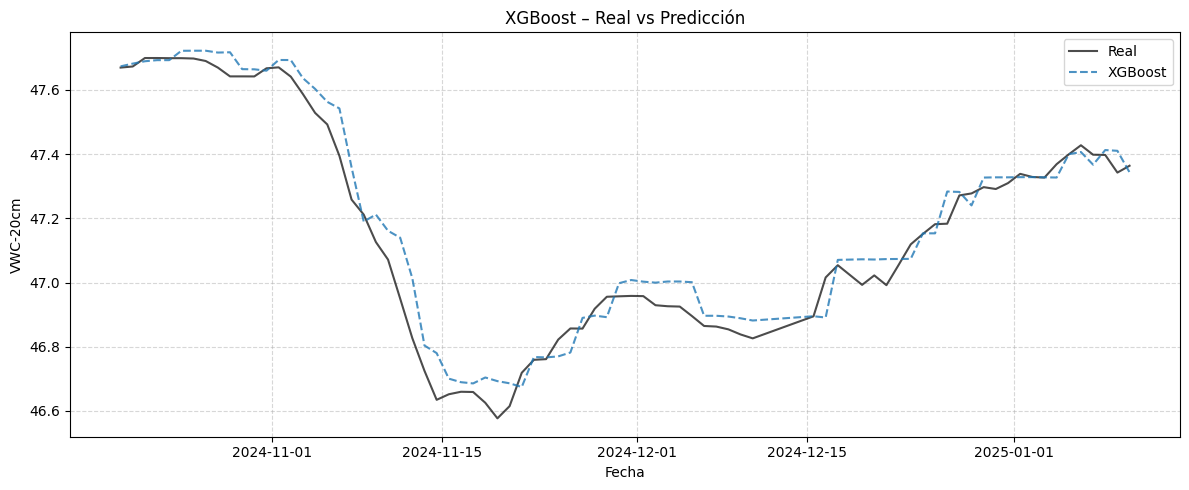

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics        import mean_squared_error, r2_score
from xgboost                import XGBRegressor

df = pd.read_excel('/content/DB_CropX_Aguacate.xlsx', sheet_name='CropX_BA29')
df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])
df = df.set_index('Fecha_Hora').sort_index().asfreq('D')
target = 'VWC-20cm'

# 2) Split cronológico 70/30
# --------------------------
split = int(len(df) * 0.7)
train_df = df.iloc[:split].copy()
test_df  = df.iloc[split:].copy()

# 3) Preparar lag‑features para XGBoost
# -------------------------------------
def make_lag_features(df, lags=[1,2,3,7]):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f'{target}_lag{lag}'] = df[target].shift(lag)
    for col in ['VWC-41cm','Temp(C)-20cm','EC(dS/m)-20cm']:
        X[f'{col}_lag1'] = df[col].shift(1)
    return X.dropna()

X_lags = make_lag_features(df)
y_lags = df[target].loc[X_lags.index]

split2 = int(len(X_lags) * 0.7)
X_train, X_test = X_lags.iloc[:split2], X_lags.iloc[split2:]
y_train, y_test = y_lags.iloc[:split2], y_lags.iloc[split2:]
t_test_lags     = X_test.index

# 4) Escalado y filtrado NaN en XGBoost
# -------------------------------------
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

mask_tr = np.isfinite(y_train)
X_train_s, y_train = X_train_s[mask_tr], y_train[mask_tr]

mask_te = np.isfinite(y_test)
X_test_s, y_test, t_test_lags = X_test_s[mask_te], y_test[mask_te], t_test_lags[mask_te]
# 2) Entrenar XGBoost
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_s, y_train)

# 3) Predicción y métricas
y_preb_train = xgb.predict(X_train_s)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_preb_train))
r2_train     = r2_score(y_train, y_preb_train)
print(f"XGBoost (train) — RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")

y_pred_xgb = xgb.predict(X_test_s)
rmse_xgb   = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb     = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

# 4) Tabla de resultados
results = pd.DataFrame(
    [['XGBoost', rmse_xgb, r2_xgb]],
    columns=['Modelo','RMSE','R2']
).set_index('Modelo')
print("\nDesempeño XGBoost en TEST:")
print(results, '\n')

# 5) Gráfica Real vs Predicción
plt.figure(figsize=(12,5))
plt.plot(t_test_lags, y_test,    'k-',  label='Real', alpha=0.7)
plt.plot(t_test_lags, y_pred_xgb,'C0--',label='XGBoost', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel(target)
plt.title('XGBoost – Real vs Predicción')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


XGBoost — Train:  RMSE=0.0011, R²=1.0000
XGBoost — Test:   RMSE=0.0542, R²=0.9727

Desempeño XGBoost en TEST:
             RMSE        R2
Modelo                     
XGBoost  0.054171  0.972704 



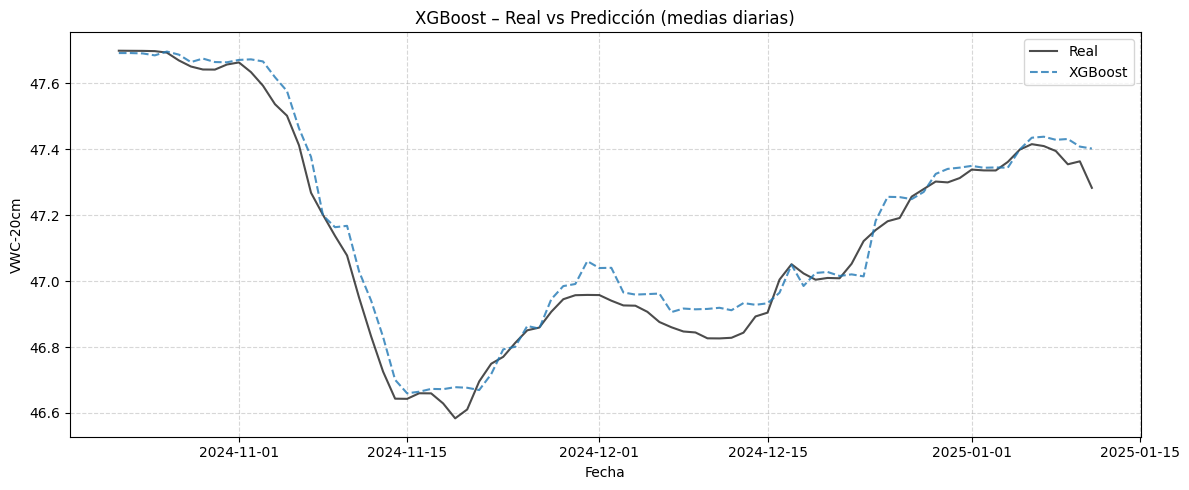

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics        import mean_squared_error, r2_score
from xgboost                import XGBRegressor

# 1) Carga y resample a medias diarias
# ------------------------------------
df = pd.read_excel(
    '/content/DB_CropX_Aguacate.xlsx',
    sheet_name='CropX_BA29',
    parse_dates=['Fecha_Hora'],
    index_col='Fecha_Hora'
)
# agrupamos por día (D) y calculamos la media:

df_daily = df.resample('D').mean(numeric_only=True)

target = 'VWC-20cm'

# 2) Split cronológico 70/30 sobre df_daily
# ------------------------------------------
split = int(len(df_daily) * 0.7)
train_df = df_daily.iloc[:split].copy()
test_df  = df_daily.iloc[split:].copy()

# 3) Función para crear lag‑features
# ----------------------------------
def make_lag_features(df, lags=[1,2,3,7]):
    X = pd.DataFrame(index=df.index)
    # retrasos sobre el target
    for lag in lags:
        X[f'{target}_lag{lag}'] = df[target].shift(lag)
    # retraso 1 día de otros sensores
    for col in ['VWC-41cm', 'Temp(C)-20cm', 'EC(dS/m)-20cm']:
        if col in df.columns:
            X[f'{col}_lag1'] = df[col].shift(1)
    return X.dropna()

# 4) Construcción de X_lags, y_lags y split intermedio
# ----------------------------------------------------
X_lags = make_lag_features(df_daily)
y_lags = df_daily[target].loc[X_lags.index]

split2    = int(len(X_lags) * 0.7)
X_train   = X_lags.iloc[:split2]
X_test    = X_lags.iloc[split2:]
y_train   = y_lags.iloc[:split2]
y_test    = y_lags.iloc[split2:]
t_test_lags = X_test.index  # para graficar

# 5) Escalado y limpieza de NaN
# ------------------------------
scaler    = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

mask_tr   = np.isfinite(y_train)
X_train_s = X_train_s[mask_tr]
y_train   = y_train[mask_tr]

mask_te   = np.isfinite(y_test)
X_test_s  = X_test_s[mask_te]
y_test    = y_test[mask_te]
t_test_lags = t_test_lags[mask_te]

# 6) Entrenar XGBoost
# --------------------
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_s, y_train)

# 7) Predicción y métricas
# -------------------------
y_pred_train = xgb.predict(X_train_s)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train     = r2_score(y_train, y_pred_train)

y_pred_xgb   = xgb.predict(X_test_s)
rmse_test    = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_test      = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — Train:  RMSE={rmse_train:.4f}, R²={r2_train:.4f}")
print(f"XGBoost — Test:   RMSE={rmse_test:.4f}, R²={r2_test:.4f}")

# 8) Tabla de resultados en TEST
# -------------------------------
results = pd.DataFrame(
    [['XGBoost', rmse_test, r2_test]],
    columns=['Modelo','RMSE','R2']
).set_index('Modelo')
print("\nDesempeño XGBoost en TEST:")
print(results, '\n')

# 9) Gráfica Real vs Predicción
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(t_test_lags, y_test,     'k-',  label='Real',    alpha=0.7)
plt.plot(t_test_lags, y_pred_xgb, 'C0--', label='XGBoost', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel(target)
plt.title('XGBoost – Real vs Predicción (medias diarias)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


XGBoost — RMSE: 0.0249, R²: 0.9533

Desempeño XGBoost en TEST:
             RMSE        R2
Modelo                     
XGBoost  0.024868  0.953331 



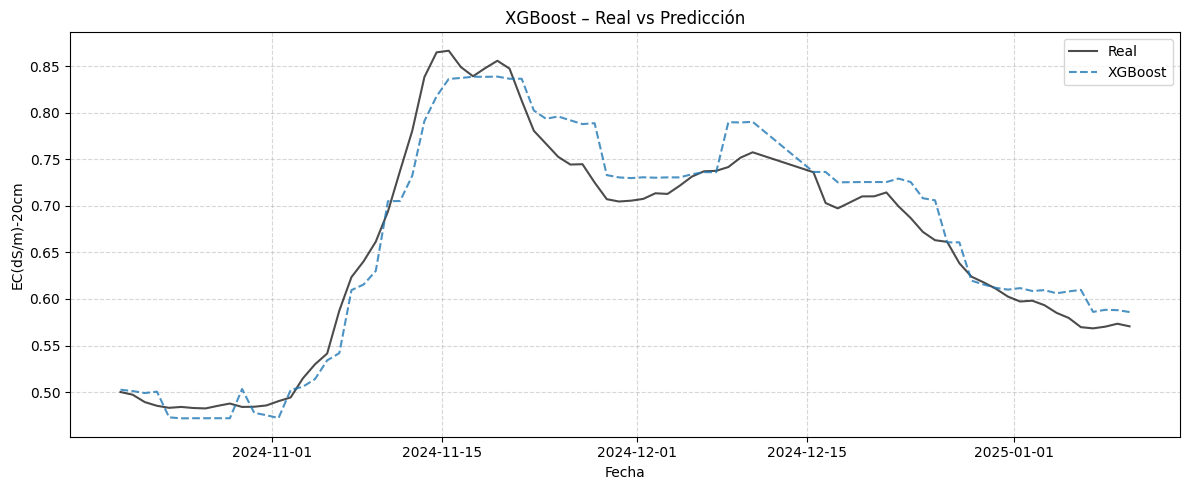

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics        import mean_squared_error, r2_score
from xgboost                import XGBRegressor

df = pd.read_excel('/content/DB_CropX_Aguacate.xlsx', sheet_name='CropX_BA29')
df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])
df = df.set_index('Fecha_Hora').sort_index().asfreq('D')
target = 'EC(dS/m)-20cm'

# 2) Split cronológico 70/30
# --------------------------
split = int(len(df) * 0.7)
train_df = df.iloc[:split].copy()
test_df  = df.iloc[split:].copy()

# 3) Preparar lag‑features para XGBoost
# -------------------------------------
def make_lag_features(df, lags=[1,2,3,7]):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f'{target}_lag{lag}'] = df[target].shift(lag)
    for col in ['VWC-41cm','Temp(C)-20cm','VWC-20cm']:
        X[f'{col}_lag1'] = df[col].shift(1)
    return X.dropna()

X_lags = make_lag_features(df)
y_lags = df[target].loc[X_lags.index]

split2 = int(len(X_lags) * 0.7)
X_train, X_test = X_lags.iloc[:split2], X_lags.iloc[split2:]
y_train, y_test = y_lags.iloc[:split2], y_lags.iloc[split2:]
t_test_lags     = X_test.index

# 4) Escalado y filtrado NaN en XGBoost
# -------------------------------------
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

mask_tr = np.isfinite(y_train)
X_train_s, y_train = X_train_s[mask_tr], y_train[mask_tr]

mask_te = np.isfinite(y_test)
X_test_s, y_test, t_test_lags = X_test_s[mask_te], y_test[mask_te], t_test_lags[mask_te]
# 2) Entrenar XGBoost
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_s, y_train)

# 3) Predicción y métricas
y_preb_train = xgb.predict(X_train_s)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_preb_train))
r2_train     = r2_score(y_train, y_preb_train)
y_pred_xgb = xgb.predict(X_test_s)
rmse_xgb   = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb     = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

# 4) Tabla de resultados
results = pd.DataFrame(
    [['XGBoost', rmse_xgb, r2_xgb]],
    columns=['Modelo','RMSE','R2']
).set_index('Modelo')
print("\nDesempeño XGBoost en TEST:")
print(results, '\n')

# 5) Gráfica Real vs Predicción
plt.figure(figsize=(12,5))
plt.plot(t_test_lags, y_test,    'k-',  label='Real', alpha=0.7)
plt.plot(t_test_lags, y_pred_xgb,'C0--',label='XGBoost', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel(target)
plt.title('XGBoost – Real vs Predicción')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


XGBoost — Train:  RMSE=0.0010, R²=1.0000
XGBoost — Test:   RMSE=0.0241, R²=0.9527

Desempeño XGBoost en TEST:
             RMSE        R2
Modelo                     
XGBoost  0.024062  0.952737 



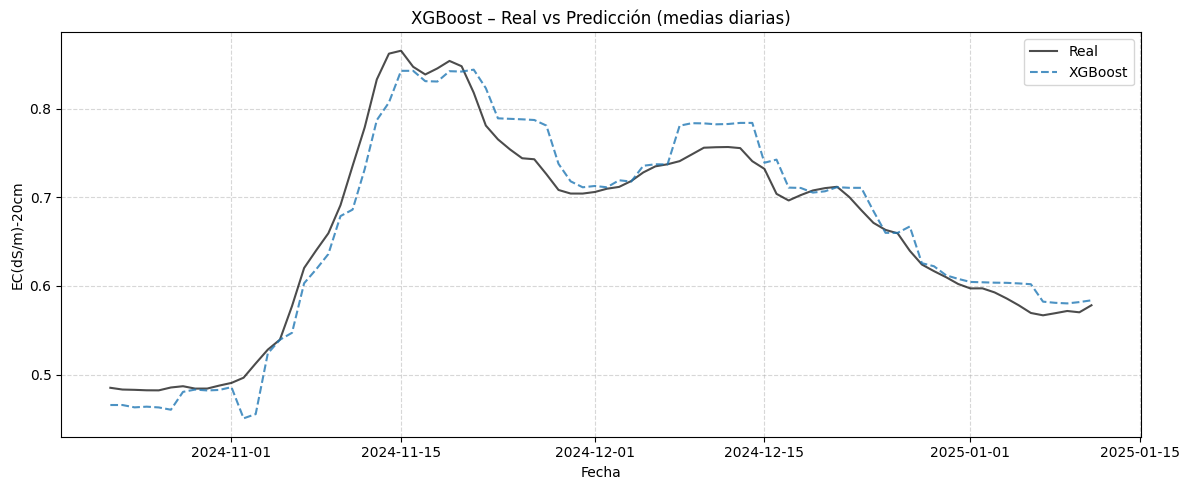

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics        import mean_squared_error, r2_score
from xgboost                import XGBRegressor

# 1) Carga y resample a medias diarias
# ------------------------------------
df = pd.read_excel(
    '/content/DB_CropX_Aguacate.xlsx',
    sheet_name='CropX_BA29',
    parse_dates=['Fecha_Hora'],
    index_col='Fecha_Hora'
)
# agrupamos por día (D) y calculamos la media:

df_daily = df.resample('D').mean(numeric_only=True)

target = 'EC(dS/m)-20cm'

# 2) Split cronológico 70/30 sobre df_daily
# ------------------------------------------
split = int(len(df_daily) * 0.7)
train_df = df_daily.iloc[:split].copy()
test_df  = df_daily.iloc[split:].copy()

# 3) Función para crear lag‑features
# ----------------------------------
def make_lag_features(df, lags=[1,2,3,7]):
    X = pd.DataFrame(index=df.index)
    # retrasos sobre el target
    for lag in lags:
        X[f'{target}_lag{lag}'] = df[target].shift(lag)
    # retraso 1 día de otros sensores
    for col in ['VWC-20cm', 'Temp(C)-20cm', 'EC(dS/m)-41cm']:
        if col in df.columns:
            X[f'{col}_lag1'] = df[col].shift(1)
    return X.dropna()

# 4) Construcción de X_lags, y_lags y split intermedio
# ----------------------------------------------------
X_lags = make_lag_features(df_daily)
y_lags = df_daily[target].loc[X_lags.index]

split2    = int(len(X_lags) * 0.7)
X_train   = X_lags.iloc[:split2]
X_test    = X_lags.iloc[split2:]
y_train   = y_lags.iloc[:split2]
y_test    = y_lags.iloc[split2:]
t_test_lags = X_test.index  # para graficar

# 5) Escalado y limpieza de NaN
# ------------------------------
scaler    = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

mask_tr   = np.isfinite(y_train)
X_train_s = X_train_s[mask_tr]
y_train   = y_train[mask_tr]

mask_te   = np.isfinite(y_test)
X_test_s  = X_test_s[mask_te]
y_test    = y_test[mask_te]
t_test_lags = t_test_lags[mask_te]

# 6) Entrenar XGBoost
# --------------------
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_s, y_train)

# 7) Predicción y métricas
# -------------------------
y_pred_train = xgb.predict(X_train_s)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train     = r2_score(y_train, y_pred_train)

y_pred_xgb   = xgb.predict(X_test_s)
rmse_test    = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_test      = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — Train:  RMSE={rmse_train:.4f}, R²={r2_train:.4f}")
print(f"XGBoost — Test:   RMSE={rmse_test:.4f}, R²={r2_test:.4f}")

# 8) Tabla de resultados en TEST
# -------------------------------
results = pd.DataFrame(
    [['XGBoost', rmse_test, r2_test]],
    columns=['Modelo','RMSE','R2']
).set_index('Modelo')
print("\nDesempeño XGBoost en TEST:")
print(results, '\n')

# 9) Gráfica Real vs Predicción
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(t_test_lags, y_test,     'k-',  label='Real',    alpha=0.7)
plt.plot(t_test_lags, y_pred_xgb, 'C0--', label='XGBoost', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel(target)
plt.title('XGBoost – Real vs Predicción (medias diarias)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
print(t_test_lags[0])
print(t_test_lags[-1])

2024-10-22 00:00:00
2025-01-11 00:00:00


# **Sistema Alarmas - Predicción**

## **Librerías**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from pyod.models.mad import MAD
from collections import defaultdict
import json
from tabulate import tabulate
import datetime
from xgboost import XGBRegressor
from typing import Dict, Any

## **Sistema de alarmas con XGBoost**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from pyod.models.mad import MAD
from collections import defaultdict
import json
from tabulate import tabulate
import datetime

# --- CONFIGURACIÓN DE RANGOS Y MENSAJES ---
RANGOS_OPTIMOS_AGUACATE = {
    "moisture_top":       (0, 100),
    "moisture_medium":    (0, 100),
    "temperature_top":    (15, 24),
    "temperature_medium": (15, 24),
    "conductivity_top":   (0.3, 3.0),
    "conductivity_medium":(0.3, 3.0),
}
MENSAJES_ADVERTENCIA_AGUACATE = {
    "moisture_low":       "Causará marchitamiento y caída de hojas.",
    "moisture_high":      "Riesgo de enfermedades y asfixia radicular.",
    "temperature_low":    "Afecta el crecimiento y desarrollo del fruto.",
    "temperature_high":   "Puede provocar la caída de flores y frutos jóvenes.",
    "conductivity_low":   "Puede limitar la disponibilidad de nutrientes.",
    "conductivity_high":  "Puede causar estrés salino y afectar rendimiento.",
}

# --- TRANSFORMACIÓN DE HUMEDAD ---
def transformar_moisture_aguacate(valor: float, capa: str) -> float:
    """
    Transforma el valor del sensor de humedad a porcentaje según la capa.
    """
    if capa == "top":
        return (valor - 20) / (40 - 20) * 100
    elif capa == "medium":
        return (valor - 25) / (45 - 25) * 100
    elif capa == "bottom":
        return (valor - 30) / (50 - 30) * 100
    return valor

# --- EVALUACIÓN Y DETECCIÓN DE ATÍPICOS ---
def evaluar_variable(nombre: str, valor: float):
    mn, mx = RANGOS_OPTIMOS_AGUACATE[nombre]
    base = nombre.split('_')[0]
    if valor < mn:
        return "bajo", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_low", "")
    if valor > mx:
        return "alto", MENSAJES_ADVERTENCIA_AGUACATE.get(f"{base}_high", "")
    return "ok", ""

def detectar_atipicos(df: pd.DataFrame) -> dict:
    df_clean = df.dropna(axis=1, how="all")
    if df_clean.shape[0] < 5:
        return {}
    scaler = StandardScaler()
    X_std = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)
    outliers = {}
    mad = MAD(threshold=3.0)
    for col in X_std.columns:
        cnt = int(mad.fit_predict(X_std[[col]].values).sum())
        if cnt: outliers[col] = cnt
    return outliers

# --- FUNCIÓN PRINCIPAL (SISTEMA DE ALARMAS) ---
# Modificado para aceptar un DataFrame pre-filtrado
def analyze_agucate_df_for_date(df_for_analysis: pd.DataFrame) -> dict:
    """
    Analiza el DataFrame proporcionado (ya filtrado para una fecha específica)
    en busca de valores fuera de rango y atípicos.
    """
    # Renombrar columnas según el mapeo esperado por el sistema de alarmas
    mapping = {
        'VWC-20cm':      'moisture_top',
        'VWC-41cm':      'moisture_medium',
        'Temp(C)-20cm':  'temperature_top',
        'Temp(C)-41cm':  'temperature_medium',
        'EC(dS/m)-20cm': 'conductivity_top',
        'EC(dS/m)-41cm': 'conductivity_medium'
    }
    # Crear una copia para evitar SettingWithCopyWarning
    df_processed = df_for_analysis.rename(columns=mapping).copy()

    vars_eval = list(mapping.values())

    # Aplicar transformación de humedad
    for capa in ['top', 'medium', 'bottom']:
        col = f"moisture_{capa}"
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].apply(lambda v: transformar_moisture_aguacate(v, capa) if pd.notna(v) else v)

    df_eval = df_processed[vars_eval].astype(float)

    # Evaluación fuera de rango
    fuera, warns = defaultdict(int), defaultdict(set)
    for col in vars_eval:
        for val in df_eval[col].dropna():
            est, msg = evaluar_variable(col, val)
            if est != "ok":
                fuera[col] += 1
                if msg: warns[col].add(msg)

    # Atípicos
    atip = detectar_atipicos(df_eval)

    # Reporte
    rep = {"resumen":"", "fuera_rango":{}, "atipicos":{}}
    if fuera:
        rep["resumen"]="Se detectaron valores fuera de rango."
        for v,c in fuera.items():
            rep["fuera_rango"][v] = {"registros_fuera":c, "advertencias":list(warns[v])}
    else:
        rep["resumen"]="Todas las variables dentro de rango."
    rep["atipicos"] = {v:{"valores_atipicos":cnt} for v,cnt in atip.items()} if atip else "No se detectaron datos atípicos."
    return rep

# --- FUNCIÓN PARA CREAR LAG-FEATURES ---
def make_lag_features(df, target_col, other_cols, lags=[1,2,3,7]):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    for col in other_cols:
        if col in df.columns:
            X[f'{col}_lag1'] = df[col].shift(1)
    return X.dropna()

# --- ENTRENAMIENTO Y PREDICCIÓN (FUNCIÓN GENERALIZADA) ---
def train_and_predict(df_daily_full: pd.DataFrame, target_column: str, other_lag_cols: list, date_to_predict_from: datetime.datetime):

    # 1. División de datos de entrenamiento/prueba en el df_daily completo (para robustez del modelo)
    X_lags_full = make_lag_features(df_daily_full, target_column, other_lag_cols)
    y_lags_full = df_daily_full[target_column].loc[X_lags_full.index]

    split2 = int(len(X_lags_full) * 0.7)
    X_train_data = X_lags_full.iloc[:split2]
    y_train_data = y_lags_full.iloc[:split2]

    scaler = StandardScaler().fit(X_train_data) # Scaler ajustado en los datos de entrenamiento
    X_train_s = scaler.transform(X_train_data)

    mask_tr = np.isfinite(y_train_data)
    X_train_s = X_train_s[mask_tr]
    y_train_data = y_train_data[mask_tr]

    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train_s, y_train_data)

    # 2. Preparar datos para la predicción para la 'fecha_a_predecir_desde' específica

    # Filtrar df_daily_full para incluir solo datos hasta e incluyendo 'fecha_a_predecir_desde'
    df_daily_for_prediction_context = df_daily_full[df_daily_full.index <= date_to_predict_from]

    if df_daily_for_prediction_context.empty:
        return np.nan

    # La fecha real para la que queremos predecir (mañana en relación con 'fecha_a_predecir_desde')
    prediction_date = date_to_predict_from + pd.Timedelta(days=1)

    # Crear un DataFrame vacío para la entrada de una sola predicción
    prediction_input = pd.DataFrame(index=[prediction_date])

    # Rellenar prediction_input con características de rezago utilizando datos de df_daily_for_prediction_context
    for lag in [1, 2, 3, 7]:
        past_date_for_lag = prediction_date - pd.Timedelta(days=lag)
        if past_date_for_lag in df_daily_for_prediction_context.index:
            prediction_input[f'{target_column}_lag{lag}'] = df_daily_for_prediction_context.loc[past_date_for_lag, target_column]
        else:
            prediction_input[f'{target_column}_lag{lag}'] = np.nan

    for col in other_lag_cols:
        past_date_for_lag1 = prediction_date - pd.Timedelta(days=1)
        if past_date_for_lag1 in df_daily_for_prediction_context.index and col in df_daily_for_prediction_context.columns:
             prediction_input[f'{col}_lag1'] = df_daily_for_prediction_context.loc[past_date_for_lag1, col]
        else:
            prediction_input[f'{col}_lag1'] = np.nan

    # Reindexar para asegurar que todas las características del modelo estén presentes y en el orden correcto
    prediction_input = prediction_input.reindex(columns=X_train_data.columns, fill_value=np.nan)

    # Imputar cualquier NaN restante para la fila de entrada de predicción
    for col_name in prediction_input.columns:
        if pd.isna(prediction_input.loc[prediction_date, col_name]):
            original_col_name_parts = col_name.split('_lag')
            original_col_name = original_col_name_parts[0]

            if original_col_name in df_daily_for_prediction_context.columns:
                last_valid_val_series = df_daily_for_prediction_context[original_col_name].dropna()
                if not last_valid_val_series.empty:
                    prediction_input.loc[prediction_date, col_name] = last_valid_val_series.iloc[-1]
                else:
                    prediction_input.loc[prediction_date, col_name] = 0 # Valor predeterminado de respaldo

    # Escalar la entrada y realizar la predicción
    prediction_input_s = scaler.transform(prediction_input)
    next_day_prediction = xgb.predict(prediction_input_s)[0]

    return next_day_prediction

# --- GENERAR REPORTE HTML ---
def generate_html_report(alarm_report: dict, predictions: dict, date: str) -> str:
    html_content = f"""
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Reporte de Monitoreo de Aguacate - {date}</title>
        <style>
            body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; line-height: 1.6; color: #333; margin: 0; padding: 20px; background-color: #f4f4f4; }}
            .container {{ max-width: 900px; margin: 20px auto; background: #fff; padding: 30px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); }}
            h1, h2 {{ color: #2c3e50; border-bottom: 2px solid #e0e0e0; padding-bottom: 10px; margin-top: 30px; }}
            h1 {{ text-align: center; color: #28a745; }}
            .section {{ margin-bottom: 25px; }}
            table {{ width: 100%; border-collapse: collapse; margin-top: 15px; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
            th {{ background-color: #f8f8f8; font-weight: bold; color: #555; }}
            .summary-box {{ background-color: #e9f7ef; border-left: 5px solid #28a745; padding: 15px; margin-top: 20px; border-radius: 5px; }}
            .warning {{ color: #dc3545; font-weight: bold; }}
            .info {{ color: #007bff; }}
            .prediction-box {{ background-color: #e0f7fa; border-left: 5px solid #007bff; padding: 15px; margin-top: 20px; border-radius: 5px; }}
            .footer {{ text-align: center; margin-top: 40px; font-size: 0.9em; color: #777; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Reporte Diario de Monitoreo de Aguacate</h1>
            <p style="text-align: center; font-size: 1.1em; color: #555;">Fecha del reporte: <strong>{date}</strong></p>

            <hr>

            <div class="section">
                <h2>Sistema de Alarmas</h2>
                <div class="summary-box">
                    <p><strong>Resumen:</strong> {alarm_report.get('resumen', '—')}</p>
                </div>

                <h3>Valores fuera de rango</h3>
                """
    fr = alarm_report.get("fuera_rango", {})
    if fr:
        html_content += """
                <table>
                    <thead>
                        <tr>
                            <th>Variable</th>
                            <th>N° Registros fuera</th>
                            <th>Advertencias</th>
                        </tr>
                    </thead>
                    <tbody>
        """
        for var, info in fr.items():
            warnings = "; ".join(info.get("advertencias", []))
            html_content += f"""
                        <tr>
                            <td>{var}</td>
                            <td>{info.get("registros_fuera", 0)}</td>
                            <td class="warning">{warnings}</td>
                        </tr>
            """
        html_content += """
                    </tbody>
                </table>
        """
    else:
        html_content += """
                <p>No se detectaron valores fuera de rango.</p>
        """

    html_content += """
                <h3>Valores atípicos</h3>
                """
    at = alarm_report.get("atipicos", {})
    if isinstance(at, dict) and at:
        if all(isinstance(v, dict) and "valores_atipicos" in v for v in at.values()):
            html_content += """
                <table>
                    <thead>
                        <tr>
                            <th>Variable</th>
                            <th>N° Valores atípicos</th>
                        </tr>
                    </thead>
                    <tbody>
            """
            for var, info in at.items():
                html_content += f"""
                        <tr>
                            <td>{var}</td>
                            <td>{info.get("valores_atipicos", 0)}</td>
                        </tr>
                """
            html_content += """
                    </tbody>
                </table>
            """
        else:
            html_content += f"<p>Atípicos: {json.dumps(at, ensure_ascii=False)}</p>"
    else:
        html_content += """
                <p>No se detectaron datos atípicos.</p>
        """

    html_content += f"""
            </div>

            <hr>

            <div class="section">
                <h2>Predicciones para el Día Siguiente</h2>
                <div class="prediction-box">
                    <p>Fecha de predicción: <strong>{(pd.to_datetime(date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')}</strong></p>
                    <ul>
                        <li><strong>Humedad a 20cm (VWC-20cm):</strong> {predictions.get('VWC-20cm', 'N/A'):.2f} %</li>
                        <li><strong>Conductividad a 20cm (EC(dS/m)-20cm):</strong> {predictions.get('EC(dS/m)-20cm', 'N/A'):.2f} dS/m</li>
                    </ul>
                </div>
            </div>

            <div class="footer">
                <p>&copy; {datetime.datetime.now().year} Sistema de Monitoreo de Cultivos. Todos los derechos reservados.</p>
            </div>
        </div>
    </body>
    </html>
    """
    return html_content


# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    path_excel = "/content/DB_CropX_Aguacate.xlsx"
    sheet_name = "CropX_BA29"

    # Carga el DataFrame completo con todos los registros
    df_raw = pd.read_excel(
        path_excel,
        sheet_name=sheet_name,
        parse_dates=['Fecha_Hora'],
        index_col='Fecha_Hora'
    )

    # Crea el DataFrame de medias diarias (df_daily) a partir de df_raw para los modelos predictivos
    df_daily = df_raw.resample('D').mean(numeric_only=True)

    # --- ENTRADA DEL USUARIO ---
    # Establece una fecha para la prueba (ej., una fecha que exista en tu conjunto de datos)
    # Para el ejemplo, usaremos una fecha con datos reales para el día siguiente si es posible.
    # El día siguiente a 2024-08-06 es 2024-08-07. Asegúrate de que el 2024-08-07 esté en tu df_daily.
    input_date_str = "2024-12-06"
    input_date_dt = pd.to_datetime(input_date_str) # Convierte a datetime para facilitar la comparación

    # Comprobaciones de validación
    required_history_days = 7 # el rezago máximo es de 7 días

    # 1. Comprueba si la fecha de entrada existe en los datos brutos (de alta frecuencia) para el informe de alarmas
    # Normalizamos el índice solo a la parte de la fecha para la comparación
    if input_date_dt.normalize() not in df_raw.index.normalize().unique():
        print(f"Error: La fecha '{input_date_str}' no se encuentra en los datos de la base de datos (registros de alta frecuencia). Por favor, ingrese una fecha válida que esté presente en 'Fecha_Hora'.")
    # 2. Comprueba si hay suficientes datos históricos *diarios* para los rezagos necesarios para la predicción
    # Esta comprobación se realiza en df_daily, que ha sido remuestreado
    elif input_date_dt < df_daily.index[required_history_days]:
        print(f"Error: La fecha '{input_date_str}' no tiene suficientes datos históricos diarios para generar todas las variables de rezago. Por favor, ingrese una fecha posterior al {df_daily.index[required_history_days].strftime('%Y-%m-%d')}.")
    else:
        # --- Procesamiento del Sistema de Alarmas ---
        # Filtra los datos brutos de alta frecuencia para la fecha de entrada especificada
        df_for_alarm_analysis = df_raw[df_raw.index.normalize() == input_date_dt.normalize()].copy()

        # Pasa este DataFrame de alta frecuencia filtrado a la función de análisis de alarmas
        alarm_report_for_date = analyze_agucate_df_for_date(df_for_alarm_analysis)

        # --- Procesamiento de Modelos Predictivos ---
        predictions = {}

        # Predicción para 'VWC-20cm'
        target_moisture = 'VWC-20cm'
        other_cols_moisture = ['VWC-41cm', 'Temp(C)-20cm', 'EC(dS/m)-20cm']
        # Pasa el df_daily completo y la fecha específica desde la que se va a predecir
        predictions[target_moisture] = train_and_predict(df_daily, target_moisture, other_cols_moisture, input_date_dt)

        # Predicción para 'EC(dS/m)-20cm'
        target_conductivity = 'EC(dS/m)-20cm'
        other_cols_conductivity = ['VWC-20cm', 'Temp(C)-20cm', 'EC(dS/m)-41cm']
        # Pasa el df_daily completo y la fecha específica desde la que se va a predecir
        predictions[target_conductivity] = train_and_predict(df_daily, target_conductivity, other_cols_conductivity, input_date_dt)

        # --- Generar y Mostrar el Informe HTML ---
        html_output = generate_html_report(alarm_report_for_date, predictions, input_date_str)

        # Guarda el HTML en un archivo
        with open("reporte_monitoreo_aguacate_xg.html", "w", encoding="utf-8") as f:
            f.write(html_output)

        print(f"Reporte HTML generado exitosamente en 'reporte_monitoreo_aguacate_xg.html' para la fecha {input_date_str}.")

        # --- IMPRIMIR VALORES REALES DEL DÍA ANALIZADO Y DEL DÍA SIGUIENTE, Y PREDICCIONES EN CONSOLA ---
        print(f"\n--- Resumen para el Día {input_date_str} ---")

        # Obtener los valores reales del día de la base de datos (df_daily)
        real_values_input_date = {}
        if input_date_dt in df_daily.index:
            real_values_input_date['VWC-20cm'] = df_daily.loc[input_date_dt, 'VWC-20cm']
            real_values_input_date['EC(dS/m)-20cm'] = df_daily.loc[input_date_dt, 'EC(dS/m)-20cm']
        else:
            real_values_input_date['VWC-20cm'] = np.nan
            real_values_input_date['EC(dS/m)-20cm'] = np.nan

        print(f"Valores reales (promedio del día {input_date_str}):")
        print(f"  Humedad a 20cm (VWC-20cm): {real_values_input_date.get('VWC-20cm', np.nan):.2f} %")
        print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {real_values_input_date.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        # Obtener los valores reales del día siguiente (si existen en df_daily)
        next_day_date_dt = input_date_dt + pd.Timedelta(days=1)
        real_values_next_day = {}

        real_values_next_day['VWC-20cm'] = df_daily.loc[next_day_date_dt, 'VWC-20cm']
        real_values_next_day['EC(dS/m)-20cm'] = df_daily.loc[next_day_date_dt, 'EC(dS/m)-20cm']


        print(f"\nPredicciones para el Día Siguiente:")
        pred_date_display = next_day_date_dt.strftime('%Y-%m-%d')
        print(f"  Fecha de predicción: {pred_date_display}")
        print(f"  Humedad a 20cm (VWC-20cm): {predictions.get('VWC-20cm', np.nan):.2f} %")
        print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {predictions.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        print(f"\nValores Reales del Día Siguiente ({pred_date_display}):")
        if pd.isna(real_values_next_day['VWC-20cm']) and pd.isna(real_values_next_day['EC(dS/m)-20cm']):
             print("  No hay datos disponibles para esta fecha en la base de datos.")
        else:
            print(f"  Humedad a 20cm (VWC-20cm): {real_values_next_day.get('VWC-20cm', np.nan):.2f} %")
            print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {real_values_next_day.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        print("------------------------------------------")

Reporte HTML generado exitosamente en 'reporte_monitoreo_aguacate_xg.html' para la fecha 2024-12-06.

--- Resumen para el Día 2024-12-06 ---
Valores reales (promedio del día 2024-12-06):
  Humedad a 20cm (VWC-20cm): 46.88 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.74 dS/m

Predicciones para el Día Siguiente:
  Fecha de predicción: 2024-12-07
  Humedad a 20cm (VWC-20cm): 46.91 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.74 dS/m

Valores Reales del Día Siguiente (2024-12-07):
  Humedad a 20cm (VWC-20cm): 46.86 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.74 dS/m
------------------------------------------


In [ ]:
from IPython.display import HTML, display

def display_html_in_colab(file_path):
    """Displays an HTML file in an IPython.display.IFrame."""
    with open(file_path, 'r', encoding='utf-8') as f:
        html_content = f.read()
    display(HTML(html_content))

# Specify the path to your generated HTML file
html_file_path = "reporte_monitoreo_aguacate_xg.html"
display_html_in_colab(html_file_path)

## **Sistema de alarmas con RandomForest**

In [ ]:
def train_and_predict(df_daily_full: pd.DataFrame, target_column: str, other_lag_cols: list,
                      date_to_predict_from: datetime.datetime, model_params: dict):

    X_lags_full = make_lag_features(df_daily_full, target_column, other_lag_cols)
    y_lags_full = df_daily_full[target_column].loc[X_lags_full.index]

    split2 = int(len(X_lags_full) * 0.7)
    X_train_data = X_lags_full.iloc[:split2]
    y_train_data = y_lags_full.iloc[:split2]

    scaler = StandardScaler().fit(X_train_data)
    X_train_s = scaler.transform(X_train_data)

    mask_tr = np.isfinite(y_train_data)
    X_train_s = X_train_s[mask_tr]
    y_train_data = y_train_data[mask_tr]

    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, **model_params)
    rf_model.fit(X_train_s, y_train_data)

    df_daily_for_prediction_context = df_daily_full[df_daily_full.index <= date_to_predict_from]

    if df_daily_for_prediction_context.empty:
        return np.nan

    prediction_date = date_to_predict_from + pd.Timedelta(days=1)
    prediction_input = pd.DataFrame(index=[prediction_date])

    for lag in [1, 2, 3, 7]:
        past_date_for_lag = prediction_date - pd.Timedelta(days=lag)
        if past_date_for_lag in df_daily_for_prediction_context.index:
            prediction_input[f'{target_column}_lag{lag}'] = df_daily_for_prediction_context.loc[past_date_for_lag, target_column]
        else:
            prediction_input[f'{target_column}_lag{lag}'] = np.nan

    for col in other_lag_cols:
        past_date_for_lag1 = prediction_date - pd.Timedelta(days=1)
        if past_date_for_lag1 in df_daily_for_prediction_context.index and col in df_daily_for_prediction_context.columns:
             prediction_input[f'{col}_lag1'] = df_daily_for_prediction_context.loc[past_date_for_lag1, col]
        else:
            prediction_input[f'{col}_lag1'] = np.nan

    prediction_input = prediction_input.reindex(columns=X_train_data.columns, fill_value=np.nan)

    for col_name in prediction_input.columns:
        if pd.isna(prediction_input.loc[prediction_date, col_name]):
            original_col_name_parts = col_name.split('_lag')
            original_col_name = original_col_name_parts[0]

            if original_col_name in df_daily_for_prediction_context.columns:
                last_valid_val_series = df_daily_for_prediction_context[original_col_name].dropna()
                if not last_valid_val_series.empty:
                    prediction_input.loc[prediction_date, col_name] = last_valid_val_series.iloc[-1]
                else:
                    prediction_input.loc[prediction_date, col_name] = 0

    prediction_input_s = scaler.transform(prediction_input)
    next_day_prediction = rf_model.predict(prediction_input_s)[0]

    return next_day_prediction

if __name__ == "__main__":
    path_excel = "/content/DB_CropX_Aguacate.xlsx"
    sheet_name = "CropX_BA29"

    # Carga el DataFrame completo con todos los registros
    df_raw = pd.read_excel(
        path_excel,
        sheet_name=sheet_name,
        parse_dates=['Fecha_Hora'],
        index_col='Fecha_Hora'
    )

    # Crea el DataFrame de medias diarias (df_daily) a partir de df_raw para los modelos predictivos
    df_daily = df_raw.resample('D').mean(numeric_only=True)

    # --- ENTRADA DEL USUARIO ---
    # Establece una fecha para la prueba (ej., una fecha que exista en tu conjunto de datos)
    # Para el ejemplo, usaremos una fecha con datos reales para el día siguiente si es posible.
    # El día siguiente a 2024-10-06 es 2024-10-07. Asegúrate de que el 2024-10-07 esté en tu df_daily.
    input_date_str = "2024-12-06"
    input_date_dt = pd.to_datetime(input_date_str) # Convierte a datetime para facilitar la comparación

    # Comprobaciones de validación
    required_history_days = 7 # el rezago máximo es de 7 días

    # 1. Comprueba si la fecha de entrada existe en los datos brutos (de alta frecuencia) para el informe de alarmas
    # Normalizamos el índice solo a la parte de la fecha para la comparación
    if input_date_dt.normalize() not in df_raw.index.normalize().unique():
        print(f"Error: La fecha '{input_date_str}' no se encuentra en los datos de la base de datos (registros de alta frecuencia). Por favor, ingrese una fecha válida que esté presente en 'Fecha_Hora'.")
    # 2. Comprueba si hay suficientes datos históricos *diarios* para los rezagos necesarios para la predicción
    # Esta comprobación se realiza en df_daily, que ha sido remuestreado
    elif input_date_dt < df_daily.index[required_history_days]:
        print(f"Error: La fecha '{input_date_str}' no tiene suficientes datos históricos diarios para generar todas las variables de rezago. Por favor, ingrese una fecha posterior al {df_daily.index[required_history_days].strftime('%Y-%m-%d')}.")
    else:
        # --- Procesamiento del Sistema de Alarmas ---
        # Filtra los datos brutos de alta frecuencia para la fecha de entrada especificada
        df_for_alarm_analysis = df_raw[df_raw.index.normalize() == input_date_dt.normalize()].copy()

        # Pasa este DataFrame de alta frecuencia filtrado a la función de análisis de alarmas
        alarm_report_for_date = analyze_agucate_df_for_date(df_for_alarm_analysis)

        # --- Procesamiento de Modelos Predictivos ---
        predictions = {}

        # Parámetros específicos para RandomForestRegressor
        rf_params_moisture = {
            'n_estimators': 1000,
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 2,
            'max_features': 'log2' # o 'sqrt', o 0.5, etc.
        }

        rf_params_conductivity = {
            'n_estimators': 50,
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 5,
            'max_features': None # Usa todas las características
        }

        # Predicción para 'VWC-20cm' con RandomForest
        target_moisture = 'VWC-20cm'
        other_cols_moisture = ['VWC-41cm', 'Temp(C)-20cm', 'EC(dS/m)-20cm']
        predictions[target_moisture] = train_and_predict(df_daily, target_moisture, other_cols_moisture, input_date_dt, rf_params_moisture)

        # Predicción para 'EC(dS/m)-20cm' con RandomForest
        target_conductivity = 'EC(dS/m)-20cm'
        other_cols_conductivity = ['VWC-20cm', 'Temp(C)-20cm', 'EC(dS/m)-41cm']
        predictions[target_conductivity] = train_and_predict(df_daily, target_conductivity, other_cols_conductivity, input_date_dt, rf_params_conductivity)

        # --- Generar y Mostrar el Informe HTML ---
        html_output = generate_html_report(alarm_report_for_date, predictions, input_date_str)

        # Guarda el HTML en un archivo
        with open("reporte_monitoreo_aguacate_rf.html", "w", encoding="utf-8") as f: # Cambiado el nombre del archivo
            f.write(html_output)

        print(f"Reporte HTML generado exitosamente en 'reporte_monitoreo_aguacate_rf.html' para la fecha {input_date_str}.") # Cambiado el nombre del archivo

        # --- IMPRIMIR VALORES REALES DEL DÍA ANALIZADO Y DEL DÍA SIGUIENTE, Y PREDICCIONES EN CONSOLA ---
        print(f"\n--- Resumen para el Día {input_date_str} ---")

        # Obtener los valores reales del día de la base de datos (df_daily)
        real_values_input_date = {}
        if input_date_dt in df_daily.index:
            real_values_input_date['VWC-20cm'] = df_daily.loc[input_date_dt, 'VWC-20cm']
            real_values_input_date['EC(dS/m)-20cm'] = df_daily.loc[input_date_dt, 'EC(dS/m)-20cm']
        else:
            real_values_input_date['VWC-20cm'] = np.nan
            real_values_input_date['EC(dS/m)-20cm'] = np.nan

        print(f"Valores reales (promedio del día {input_date_str}):")
        print(f"  Humedad a 20cm (VWC-20cm): {real_values_input_date.get('VWC-20cm', np.nan):.2f} %")
        print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {real_values_input_date.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        # Obtener los valores reales del día siguiente (si existen en df_daily)
        next_day_date_dt = input_date_dt + pd.Timedelta(days=1)
        real_values_next_day = {}
        if next_day_date_dt in df_daily.index:
            real_values_next_day['VWC-20cm'] = df_daily.loc[next_day_date_dt, 'VWC-20cm']
            real_values_next_day['EC(dS/m)-20cm'] = df_daily.loc[next_day_date_dt, 'EC(dS/m)-20cm']
        else:
            real_values_next_day['VWC-20cm'] = np.nan
            real_values_next_day['EC(dS/m)-20cm'] = np.nan


        print(f"\nPredicciones para el Día Siguiente ({next_day_date_dt.strftime('%Y-%m-%d')}):")
        print(f"  Humedad a 20cm (VWC-20cm): {predictions.get('VWC-20cm', np.nan):.2f} %")
        print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {predictions.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        print(f"\nValores Reales del Día Siguiente ({next_day_date_dt.strftime('%Y-%m-%d')}):")
        if pd.isna(real_values_next_day['VWC-20cm']) and pd.isna(real_values_next_day['EC(dS/m)-20cm']):
             print("  No hay datos disponibles para esta fecha en la base de datos.")
        else:
            print(f"  Humedad a 20cm (VWC-20cm): {real_values_next_day.get('VWC-20cm', np.nan):.2f} %")
            print(f"  Conductividad a 20cm (EC(dS/m)-20cm): {real_values_next_day.get('EC(dS/m)-20cm', np.nan):.2f} dS/m")

        print("------------------------------------------")

Reporte HTML generado exitosamente en 'reporte_monitoreo_aguacate_rf.html' para la fecha 2024-12-06.

--- Resumen para el Día 2024-12-06 ---
Valores reales (promedio del día 2024-12-06):
  Humedad a 20cm (VWC-20cm): 46.88 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.74 dS/m

Predicciones para el Día Siguiente (2024-12-07):
  Humedad a 20cm (VWC-20cm): 46.98 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.73 dS/m

Valores Reales del Día Siguiente (2024-12-07):
  Humedad a 20cm (VWC-20cm): 46.86 %
  Conductividad a 20cm (EC(dS/m)-20cm): 0.74 dS/m
------------------------------------------


In [ ]:
from IPython.display import HTML, display

def display_html_in_colab(file_path):
    """Displays an HTML file in an IPython.display.IFrame."""
    with open(file_path, 'r', encoding='utf-8') as f:
        html_content = f.read()
    display(HTML(html_content))

# Specify the path to your generated HTML file
html_file_path = "reporte_monitoreo_aguacate_rf.html"
display_html_in_colab(html_file_path)